# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vision_utils
from matplotlib.ticker import NullFormatter

In [3]:
DEVICE = torch.device('cpu')

# Load MNIST data

In [24]:
def keep_only_lbls(dataset, lbls, device=None):
  lbls = {lbl: i for i, lbl in enumerate(lbls)}
  final_X, final_Y = [], []
  for x, y in dataset:
    if y in lbls:
      final_X.append(x)
      final_Y.append(lbls[y])
  X = torch.stack(final_X)
  Y = torch.tensor(final_Y).long()
  if device is not None:
    X = X.to(device)
    Y = Y.to(device)
  return torch.utils.data.TensorDataset(X, Y)


data_train = MNIST('./data/mnist/', train = True, download = True, transform=transforms.ToTensor())
data_train = keep_only_lbls(data_train, lbls=[0,1], device=DEVICE)
data_train, data_valid = torch.utils.data.random_split(data_train, [10000,2665])

data_test = MNIST('./data/mnist/', train = False, download = True, transform=transforms.ToTensor())
data_test = keep_only_lbls(data_test, lbls=[0,1], device=DEVICE)

train_dl = DataLoader(data_train, batch_size=256, shuffle=True)
valid_dl = DataLoader(data_valid, batch_size=1024, shuffle=False)
test_dl = DataLoader(data_test, batch_size=1024, shuffle=False)

print(f"Train length: {len(train_dl.dataset)}")
print(f"Valid length: {len(valid_dl.dataset)}")
print(f"Test length: {len(test_dl.dataset)}")

Train length: 10000
Valid length: 2665
Test length: 2115


# Build interpolated dataset

In [27]:
def plot_samples(X):
  fig = plt.figure(figsize=(10,7), dpi=130)
  grid_img = vision_utils.make_grid(X[:26].cpu(), nrow=13, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter()) 
  _ = ax.yaxis.set_major_formatter(NullFormatter()) 
  plt.show()

def build_interpolated_dataset(dl, max_pairs=500, num_ts=150, device=torch.device('cpu')):
  X_test, Y_test = dl.dataset.tensors

  X_test_0 = X_test[Y_test == 0]
  X_test_1 = X_test[Y_test == 1]

  ts = torch.tensor(np.linspace(0, 1, num_ts)) * 3 - 1

  new_X_test, ts_test = [], []

  with torch.no_grad():
    for x_0, x_1 in zip(X_test_0[:max_pairs], X_test_1[:max_pairs]):
      for t in ts:
        x = t * x_1 + (1-t) * x_0
        new_X_test.append(x.cpu())
        ts_test.append(t.item())

  X_test = torch.stack(new_X_test).to(device)
  
  return X_test, ts_test

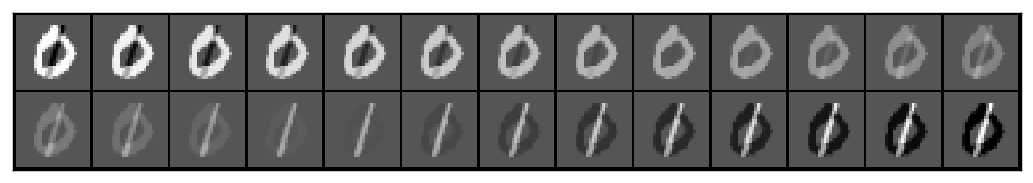

In [28]:
X_test, ts_test = build_interpolated_dataset(test_dl, max_pairs=1, num_ts=26, device=DEVICE)
plot_samples(X_test)

In [29]:
X_test, ts_test = build_interpolated_dataset(test_dl, device=DEVICE)

`X_test` consists in the interpolated $x$: $t \cdot x^{1} + (1-t) \cdot x^{0}$ for $t \in [-1,2]$ \
`ts_test` consists in the associated $t$ values

# Train a dummy classifier

In [45]:
net = nn.Sequential(nn.Flatten(1), nn.Linear(28*28, 100), nn.ReLU(), nn.Linear(100, 2))

opt = torch.optim.SGD(params=net.parameters(), lr=0.1)

for epoch in range(5):
  for x, y in train_dl:
    loss = F.cross_entropy(net(x), y)
    opt.zero_grad()
    loss.backward()
    opt.step()

  print(f"epoch {epoch}: train loss {loss.item():.3f}")

epoch 0: train loss 0.011
epoch 1: train loss 0.021
epoch 2: train loss 0.003
epoch 3: train loss 0.224
epoch 4: train loss 0.002


# Get probabilities on test

In [46]:
with torch.no_grad():
  probas = torch.softmax(net(X_test), dim=1)

# Check the entropy given t

In [47]:
with torch.no_grad():
  entropy = (-(probas * (probas+1e-8).log())).sum(dim=1).numpy()

In [48]:
ts = sorted(list(set(ts_test)))

t2idx = {t:idx for idx, t in enumerate(ts)}
entropy_per_t = [[] for _ in range(len(t2idx))] 

for t, p in zip(ts_test, entropy):
  idx = t2idx[t]
  entropy_per_t[idx].append(p)

entropy_per_t = [np.mean(x) for x in entropy_per_t]

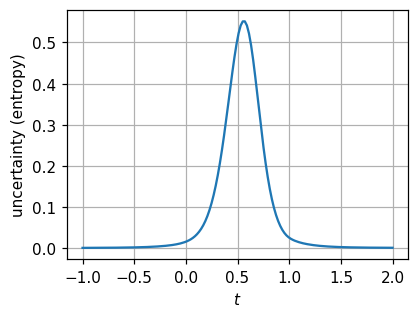

In [51]:
fig, (ax) = plt.subplots(1,1,figsize=(4,3), dpi=110)

ax.grid()

ax.set_xlabel("$t$")
ax.set_ylabel("uncertainty (entropy)")

ax.plot(ts, entropy_per_t)